<a href="https://colab.research.google.com/github/microprediction/timeseries-notebooks/blob/main/pytorch_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install microprediction


### Using pytorch to train LSTM
Get some data:

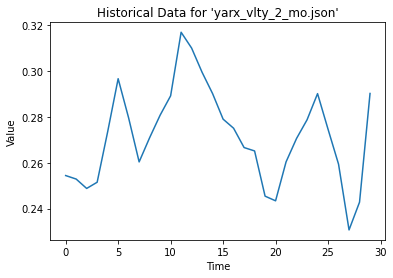

In [17]:
import matplotlib.pyplot as plt
from microprediction import MicroReader

# Initialize the MicroReader
reader = MicroReader()

# Fetch a list of stream names
stream_names = reader.get_stream_names()

# Choose the first stream from the list
stream = stream_names[50]

# Or hardwire it...
stream = 'yarx_vlty_2_mo.json'

# Fetch historical data (returns a list of values)
history = reader.get_lagged_values(name=stream)

# Plot the historical data
plt.plot(history[:30])
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Historical Data for '{stream}'")
plt.show()


In [7]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import numpy as np
import torch

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Preprocess the historical data
seq_length = 10
X, y = create_sequences(history, seq_length)

# Split the data into training and testing sets
train_size = int(len(y) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


In [19]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the LSTM model
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1
model = LSTM(input_size, hidden_size, num_layers, output_size)


In [20]:
# Set training parameters
learning_rate = 0.01
num_epochs = 100

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = model(X_train.unsqueeze(-1)).squeeze()  # Add .squeeze() here
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/100], Loss: 0.0283
Epoch [20/100], Loss: 0.0184
Epoch [30/100], Loss: 0.0163
Epoch [40/100], Loss: 0.0132
Epoch [50/100], Loss: 0.0104
Epoch [60/100], Loss: 0.0101
Epoch [70/100], Loss: 0.0097
Epoch [80/100], Loss: 0.0094
Epoch [90/100], Loss: 0.0090
Epoch [100/100], Loss: 0.0086


# Okay does it work?
Check metric on test set


In [21]:
with torch.no_grad():
    test_outputs = model(X_test.unsqueeze(-1)).squeeze()  # Add .squeeze() here
    test_loss = criterion(test_outputs, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")


Test Loss: 0.0092


Not to bad ... perhaps. 

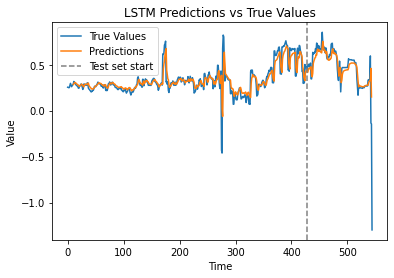

In [22]:
import matplotlib.pyplot as plt

# Concatenate the training and test predictions
with torch.no_grad():
    train_outputs = model(X_train.unsqueeze(-1)).squeeze().numpy()
    test_outputs = model(X_test.unsqueeze(-1)).squeeze().numpy()
all_outputs = np.concatenate((train_outputs, test_outputs))

# Calculate the index where the test set starts
test_start_index = len(history) - len(y_test) - seq_length

# Plot the true values and the predictions
plt.plot(history, label="True Values")
plt.plot(range(seq_length, seq_length + len(all_outputs)), all_outputs, label="Predictions")
plt.axvline(x=test_start_index, color='gray', linestyle='--', label="Test set start")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()


Let's benchmark it against something simple

In [23]:
def lstm_predict(model, input_data):
    input_data = torch.tensor(input_data).float().unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        prediction = model(input_data).squeeze().item()
    return prediction


In [ ]:
!pip install timemachines

In [25]:
from sklearn.metrics import mean_squared_error
from timemachines.skaters.simple.thinking import thinking_fast_and_slow as f 

lstm_predictions = []
fast_slow_predictions = []

s = {}
for i in range(seq_length, len(history)):
    input_data = history[i - seq_length:i]
    lstm_pred = lstm_predict(model, input_data)
    lstm_predictions.append(lstm_pred)
    fast_slow_pred, _, s = f(y=history[i - 1],s=s,k=1)
    fast_slow_predictions.append(fast_slow_pred)

lstm_mse = mean_squared_error(history[seq_length:], lstm_predictions)
fast_slow_mse = mean_squared_error(history[seq_length:], fast_slow_predictions)

print("LSTM Mean Squared Error:", lstm_mse)
print("Thinking Fast and Slow Mean Squared Error:", fast_slow_mse)


LSTM Mean Squared Error: 0.012208925602694692
Thinking Fast and Slow Mean Squared Error: 0.01473796620856306


Bravo! We beat it. 